In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import calendar


# Optional: set matplotlib inline if using a Jupyter Notebook
%matplotlib inline

In [6]:
import pandas as pd
import numpy as np

# Load the hourly data
df = pd.read_csv('../aggregated_hourly_measurements.csv')
df.set_index("Hour", inplace=True)
df.index = pd.to_datetime(df.index)

# Combine solar and grid readings, excluding solar before June 2024
df['Total_consumption'] = (df['Grid Organi lbc'] +
                           df['Solar'].where(df.index >= '2024-06-01', 0) -
                           df['Chargers'] - df['Chargers achteraan'])

# Drop unwanted columns
df.drop(['Chargers achteraan', 'Solar', 'Chargers', 'Grid Organi lbc'], axis=1, inplace=True)

# Create a complete hourly date range (including missing hours)
start_date = df.index.min()
end_date = max(df.index.max(), pd.Timestamp('2023-09-06'))  # Extend to cover the desired period
full_date_range = pd.date_range(start=start_date, end=end_date, freq='H')
df = df.reindex(full_date_range)

# Add day of week and hour of day columns for interpolation
df['day_of_week'] = df.index.dayofweek  # 0=Monday, 6=Sunday
df['hour_of_day'] = df.index.hour       # hour part of the timestamp

# --- Define Periods ---
# Period 1 (to remove)
period1_start = '2022-09-28'
period1_end = '2022-11-08'
df.loc[period1_start:period1_end, 'Total_consumption'] = np.nan  # Mark for removal
df_period1 = df.loc[period1_start:period1_end].copy()
df = df.drop(df_period1.index)

# Period 2 (to interpolate)
period2_start = '2023-08-24'
period2_end = '2023-09-06'
df.loc[period2_start:period2_end, 'Total_consumption'] = np.nan  # Mark for interpolation

# Remove Period 1 and Period 2 from the data used to calculate averages
df_remaining = df.dropna(subset=['Total_consumption'])

# Use ONLY 2023 data (excluding Period 2) to calculate hourly averages 
# based on both day of week and hour of day
df_remaining_2023 = df_remaining[df_remaining.index.year == 2023]
hourly_avg = df_remaining_2023.groupby(['day_of_week', 'hour_of_day'])['Total_consumption'].mean()

# Fill Period 2 NaN values with the calculated averages based on day-of-week and hour-of-day
for dt in pd.date_range(period2_start, period2_end, freq='H'):
    if pd.isna(df.loc[dt, 'Total_consumption']):
        d = dt.dayofweek
        h = dt.hour
        if (d, h) in hourly_avg.index:
            df.loc[dt, 'Total_consumption'] = hourly_avg.loc[(d, h)]

# --- Handle Wrong Charger Dates in 2024 by Interpolating Using 2024 Data ---
wrong_chargers_dates = pd.to_datetime([
    '2024-06-08', '2024-06-09', '2024-06-15',
    '2024-06-16', '2024-06-22', '2024-06-23'
])
# Mark all hours on these dates as NaN for interpolation
for wrong_date in wrong_chargers_dates:
    mask = df.index.normalize() == wrong_date.normalize()
    df.loc[mask, 'Total_consumption'] = np.nan

# Compute hourly averages for valid 2024 data grouped by day-of-week and hour of day
df_2024_valid = df[(df.index.year == 2024) & (df['Total_consumption'].notna())]
weekly_hourly_avg_2024 = df_2024_valid.groupby(['day_of_week', 'hour_of_day'])['Total_consumption'].mean()

# Fill in the missing values on the wrong charger dates using the 2024 averages
for wrong_date in wrong_chargers_dates:
    mask = df.index.normalize() == wrong_date.normalize()
    for dt in df[mask].index:
        d = dt.dayofweek
        h = dt.hour
        if (d, h) in weekly_hourly_avg_2024.index:
            if pd.isna(df.loc[dt, 'Total_consumption']):
                df.loc[dt, 'Total_consumption'] = weekly_hourly_avg_2024.loc[(d, h)]

# --- Final Cleanup ---
# Drop the helper columns
df = df.drop(columns=['day_of_week', 'hour_of_day'])

# Reset index to make 'Hour' a column (instead of an index)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Hour'}, inplace=True)

# Save the final DataFrame (only 'Hour' and 'Total_consumption')
df[['Hour', 'Total_consumption']].to_csv('../hourly_building_consumption.csv', index=False)

# Display the first few rows
print("Final DataFrame:")
print(df.head())


C:\Users\user\AppData\Local\Temp\ipykernel_1672\2288222178.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_date_range = pd.date_range(start=start_date, end=end_date, freq='H')
C:\Users\user\AppData\Local\Temp\ipykernel_1672\2288222178.py:49: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  for dt in pd.date_range(period2_start, period2_end, freq='H'):


Final DataFrame:
                 Hour  Total_consumption
0 2022-11-09 00:00:00             5.6620
1 2022-11-09 01:00:00             5.6104
2 2022-11-09 02:00:00             5.4822
3 2022-11-09 03:00:00             5.4978
4 2022-11-09 04:00:00             5.7415


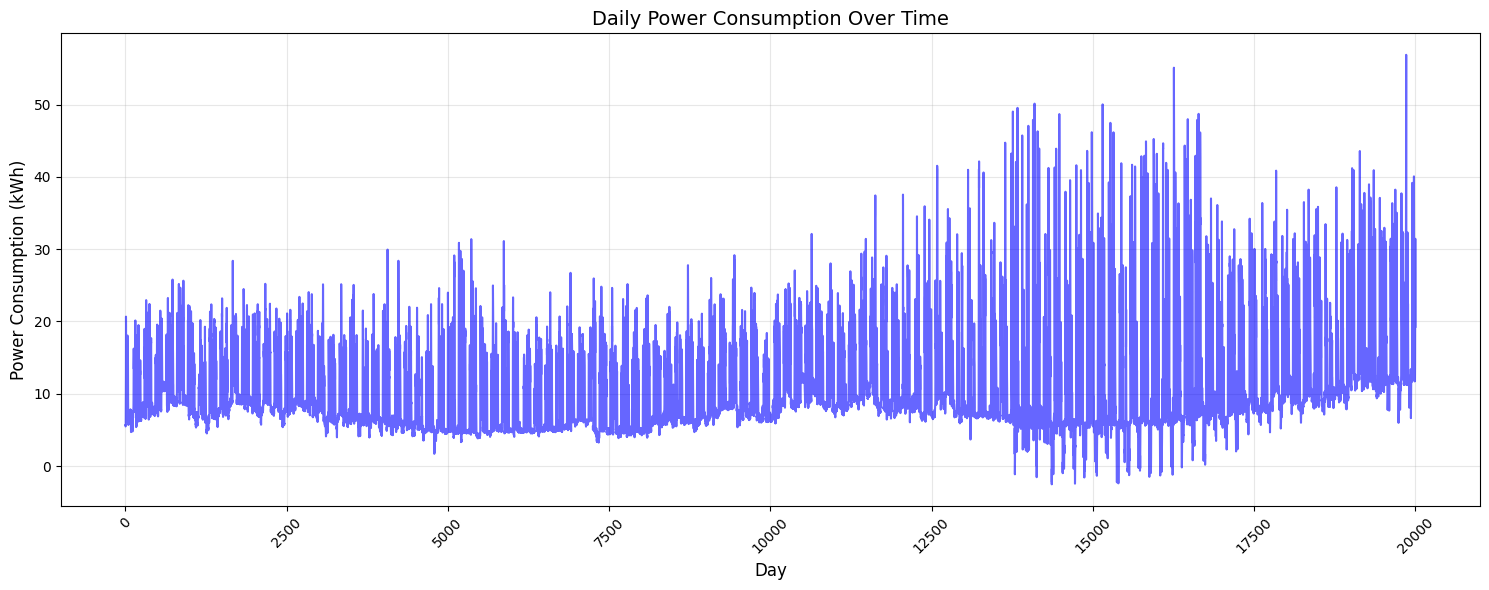

In [7]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2]:
# Ensure the index is a DatetimeIndex first
df.index = pd.to_datetime(df.index)

# Filter the DataFrame by the date range
df = df[df['Hour'] >= '2024-01-01']

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined